<a href="https://colab.research.google.com/github/anaisetienne/carpark_forecast/blob/rnn_reinis/rnn_colab_reinis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is based on the RNN recap by Dayus


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
from datetime import datetime
import random
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.optimizers.legacy import Nadam
from tensorflow.keras.optimizers import AdamW

from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer, Masking
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
from keras.callbacks import EarlyStopping

In [2]:
sns.set_theme(rc={'figure.figsize':(16,8)})

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [14]:
from google.colab import files
uploaded = files.upload()

Saving 01_06_2021_to_20_06_2023_anais.csv to 01_06_2021_to_20_06_2023_anais.csv
Saving 01_06_2021_to_20_06_2023_products_anais.csv to 01_06_2021_to_20_06_2023_products_anais.csv


In [16]:
df_bookings = pd.read_csv('01_06_2021_to_20_06_2023_anais.csv', parse_dates=[0], index_col=[0])

In [17]:
df_bookings

,nb_cars,nb_cars_cxl,nb_bookings,nb_bookings_cxl
date,,,,
2021-06-01,368,30,172,12
2021-06-02,395,34,169,4
2021-06-03,428,26,170,13
2021-06-04,412,25,424,30
2021-06-05,695,49,187,16
...,...,...,...,...
2023-06-16,1450,99,1070,58
2023-06-17,1858,112,583,37
2023-06-18,2119,121,268,12


In [18]:
# Load product dataset
df_products = pd.read_csv("01_06_2021_to_20_06_2023_products_anais.csv", parse_dates=[0], index_col=[0])

In [19]:
df_products

,hourly rate,WE package,1 week package,1 month package,other package,2 weeks package
date,,,,,,
2021-06-01,115,14,176,53,5,5
2021-06-02,160,1,171,55,3,5
2021-06-03,178,0,189,52,4,5
2021-06-04,150,0,205,48,3,6
2021-06-05,204,236,199,45,3,8
...,...,...,...,...,...,...
2023-06-16,571,239,435,178,0,27
2023-06-17,261,1018,378,175,0,26
2023-06-18,337,1199,385,172,2,24


In [20]:
# Merging DataFrames
df = df_bookings.merge(df_products, left_index=True, right_index=True)
df

,nb_cars,nb_cars_cxl,nb_bookings,nb_bookings_cxl,hourly rate,WE package,1 week package,1 month package,other package,2 weeks package
date,,,,,,,,,,
2021-06-01,368,30,172,12,115,14,176,53,5,5
2021-06-02,395,34,169,4,160,1,171,55,3,5
2021-06-03,428,26,170,13,178,0,189,52,4,5
2021-06-04,412,25,424,30,150,0,205,48,3,6
2021-06-05,695,49,187,16,204,236,199,45,3,8
...,...,...,...,...,...,...,...,...,...,...
2023-06-16,1450,99,1070,58,571,239,435,178,0,27
2023-06-17,1858,112,583,37,261,1018,378,175,0,26
2023-06-18,2119,121,268,12,337,1199,385,172,2,24


In [21]:
# This function will create a slice of data from a specified random starting position.
# The random position must be generated externally.

def get_Xi_yi(df_X,
              df_y,
              random_start,
              X_length=28,
              y_length=7):

#     must define a random_start:int for function to run
    Xi = df_X.iloc[random_start-X_length:random_start]
    yi = df_y.iloc[random_start:random_start+y_length]

    return Xi, yi


In [22]:
# The main data selection function.
# This function will generate all random slices based on the length of the dataframe passed.
# Important to note, if val state is set to true, it will only generate data slices after the val_cutoff point.

def get_X_y(df,
            X_length=28,
            y_length=7,
            number_of_sequences=51,
            number_of_targets=1,
            n_pca=0.9,
            val=False,
            val_cutoff=0.8):

#     limit dataframes to length for train/test splits
    df_X = df.copy()
    df_y = df.iloc[:, :number_of_targets].copy()

#     convert and scale X dataframe to PCA to solve dimensionality problem
    scaler = MinMaxScaler()
    df_X_scaled = scaler.fit_transform(df_X)
    pca = PCA(n_components=n_pca).fit(df_X_scaled)
    df_X_proj = pd.DataFrame(pca.transform(df_X_scaled))
    df_X_proj.index = df_X.index

#     create unique list to sample random datapoints from
    if val:
        sample_list = list(range(int(len(df_y)*val_cutoff), int(len(df_y)-y_length)))
    if not val:
        sample_list = list(range(int(X_length), int(len(df_y)-y_length)))
    random.shuffle(sample_list)

#     empty lists to append data to, will create 3D dataframe here
    X, y = [], []

#     for loop to select ith values from data
    for i in range(number_of_sequences):
        Xi, yi = get_Xi_yi(df_X_proj, df_y, sample_list.pop(-1), X_length, y_length)
        X.append(Xi.values.tolist())
        y.append(yi.values.tolist())

    return np.array(X), np.array(y)

In [24]:
# Define X_train, y_train
X_train, y_train = get_X_y(df.iloc[:int(len(df)*0.6)],
                           X_length=56,
                           y_length=7,
                           number_of_sequences=50,
                           number_of_targets=1)

In [25]:
y_train = y_train[:, :, 0]

In [26]:
print(X_train.shape, y_train.shape)

(50, 56, 6) (50, 7)


In [27]:
# Define X_val, y_val
X_val, y_val = get_X_y(df.iloc[:int(len(df)*0.8)],
                       X_length=56,
                       y_length=7,
                       number_of_sequences=15,
                       number_of_targets=1,
                       val=True,
                       val_cutoff=0.6)

In [28]:
y_val = y_val[:, :, 0]

In [29]:
print(X_val.shape, y_val.shape)

(15, 56, 6) (15, 7)


In [30]:
# Define X_test, y_tes
X_test, y_test = get_X_y(df.iloc[:int(len(df)*0.99)],
                         X_length=56,
                         y_length=7,
                         number_of_sequences=15,
                         number_of_targets=1,
                         val=True,
                         val_cutoff=0.8)

In [31]:
y_test = y_test[:, :, 0]

In [32]:
print(X_test.shape, y_test.shape)

(15, 56, 6) (15, 7)


In [33]:
df.describe()

,nb_cars,nb_cars_cxl,nb_bookings,nb_bookings_cxl,hourly rate,WE package,1 week package,1 month package,other package,2 weeks package
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.00000,750.000000
mean,1140.521333,100.865333,426.333333,36.454667,315.601333,258.121333,408.444000,131.988000,3.32000,23.046667
std,418.860198,78.975308,217.368583,37.515426,169.882720,323.391358,180.211881,53.751752,5.15309,10.025293
min,364.000000,25.000000,54.000000,3.000000,59.000000,0.000000,131.000000,38.000000,0.00000,2.000000
25%,835.500000,59.000000,247.000000,18.000000,183.500000,17.000000,299.000000,89.000000,0.00000,16.000000
50%,1084.500000,80.000000,397.000000,27.000000,271.000000,110.500000,373.000000,132.000000,1.00000,22.000000
75%,1401.500000,112.000000,548.750000,40.000000,423.750000,388.750000,454.750000,161.000000,5.00000,27.000000
max,2848.000000,752.000000,1243.000000,507.000000,988.000000,1536.000000,1405.000000,320.000000,33.00000,55.000000


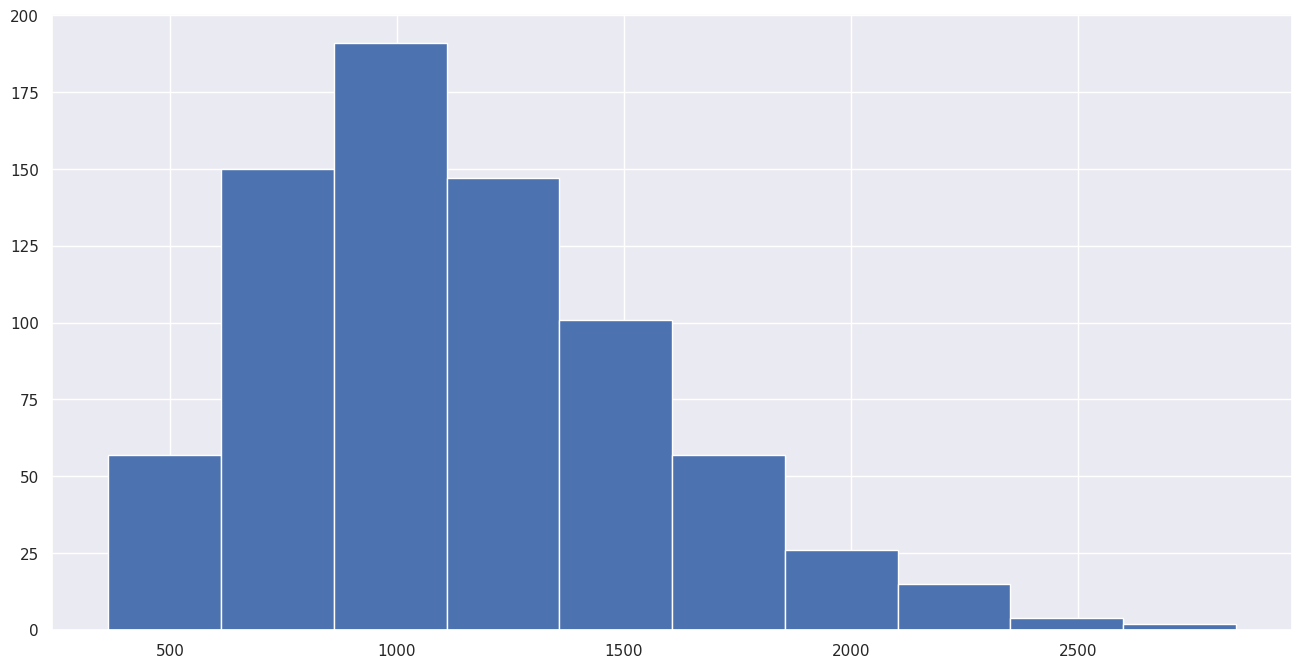

In [35]:
plt.hist(df['nb_cars']);

In [36]:
# To reduce skewness we will use a log transformations

In [37]:
# y normalize
y_scaler = MinMaxScaler()
y_scaler.fit(np.log(y_train))

y_train_scaled = y_scaler.transform(np.log(y_train))
y_test_scaled = y_scaler.transform(np.log(y_test))
y_val_scaled = y_scaler.transform(np.log(y_val))

## model

In [108]:
input_shape = X_train.shape[1:]
output_shape = y_train_scaled.shape[1]
reg = regularizers.L2(l2=0.02)

In [120]:
# instantiate model
model = Sequential()

# masking
# model.add(Masking(input_shape = input_shape))

# hidden layer architecture
model.add(LSTM(200, return_sequences=True,\
              input_shape = input_shape))

model.add(LSTM(200, return_sequences=True,
               recurrent_regularizer=reg,
               dropout=0.2
              ))

model.add(LSTM(200, return_sequences=True,
               recurrent_regularizer=reg,
               dropout=0.2
              ))

model.add(LSTM(200, return_sequences=True,
               recurrent_regularizer=reg,
               dropout=0.2
              ))

# pass final sequences
model.add(LSTM(200, return_sequences=False))

#can add dense layer
#droput layers/ recurrent dropout
#regularizers

# prediction layer
model.add(Dense(output_shape, activation = 'linear'))

In [121]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 56, 200)           165600    
                                                                 
 lstm_16 (LSTM)              (None, 56, 200)           320800    
                                                                 
 lstm_17 (LSTM)              (None, 56, 200)           320800    
                                                                 
 lstm_18 (LSTM)              (None, 56, 200)           320800    
                                                                 
 lstm_19 (LSTM)              (None, 200)               320800    
                                                                 
 dense_3 (Dense)             (None, 7)                 1407      
                                                                 
Total params: 1,450,207
Trainable params: 1,450,207
No

In [122]:
optimizer = AdamW(learning_rate=0.01,
                  beta_1=0.5,
                  beta_2=0.999)
    #learning_rate=0.00003,
                 # beta_1=0.8,
                  #epsilon=1e-18)

In [123]:
model.compile(
    loss=['logcosh'],
    metrics=['mae'],
    optimizer=optimizer
)

es = EarlyStopping(
    patience=10,
    restore_best_weights=True
)

history = model.fit(
                X_train,
                y_train_scaled,
                batch_size = 32,
                epochs = 500,
                shuffle = False,
                verbose = 2,
                validation_data = (X_val, y_val_scaled),
                #callbacks=[es]
)

Epoch 1/500
2/2 - 11s - loss: 10.5272 - mae: 0.4797 - val_loss: 6.1695 - val_mae: 2.1622 - 11s/epoch - 5s/step
Epoch 2/500
2/2 - 0s - loss: 5.3348 - mae: 1.8714 - val_loss: 3.4378 - val_mae: 2.3087 - 118ms/epoch - 59ms/step
Epoch 3/500
2/2 - 0s - loss: 2.6515 - mae: 1.5389 - val_loss: 1.8045 - val_mae: 1.2579 - 122ms/epoch - 61ms/step
Epoch 4/500
2/2 - 0s - loss: 1.5306 - mae: 1.0213 - val_loss: 0.6615 - val_mae: 0.4392 - 124ms/epoch - 62ms/step
Epoch 5/500
2/2 - 0s - loss: 0.5518 - mae: 0.3628 - val_loss: 0.2627 - val_mae: 0.2878 - 103ms/epoch - 51ms/step
Epoch 6/500
2/2 - 0s - loss: 0.2161 - mae: 0.2173 - val_loss: 0.1283 - val_mae: 0.2368 - 103ms/epoch - 51ms/step
Epoch 7/500
2/2 - 0s - loss: 0.1052 - mae: 0.1896 - val_loss: 0.0925 - val_mae: 0.2755 - 100ms/epoch - 50ms/step
Epoch 8/500
2/2 - 0s - loss: 0.0651 - mae: 0.1917 - val_loss: 0.0636 - val_mae: 0.2503 - 105ms/epoch - 53ms/step
Epoch 9/500
2/2 - 0s - loss: 0.0450 - mae: 0.1831 - val_loss: 0.0559 - val_mae: 0.2568 - 145ms/epo

# Predict

In [124]:
y_pred = model.predict(X_test)

y_pred = y_scaler.inverse_transform(y_pred)
y_pred = np.exp(y_pred)

1/1 [==============================] - 3s 3s/step


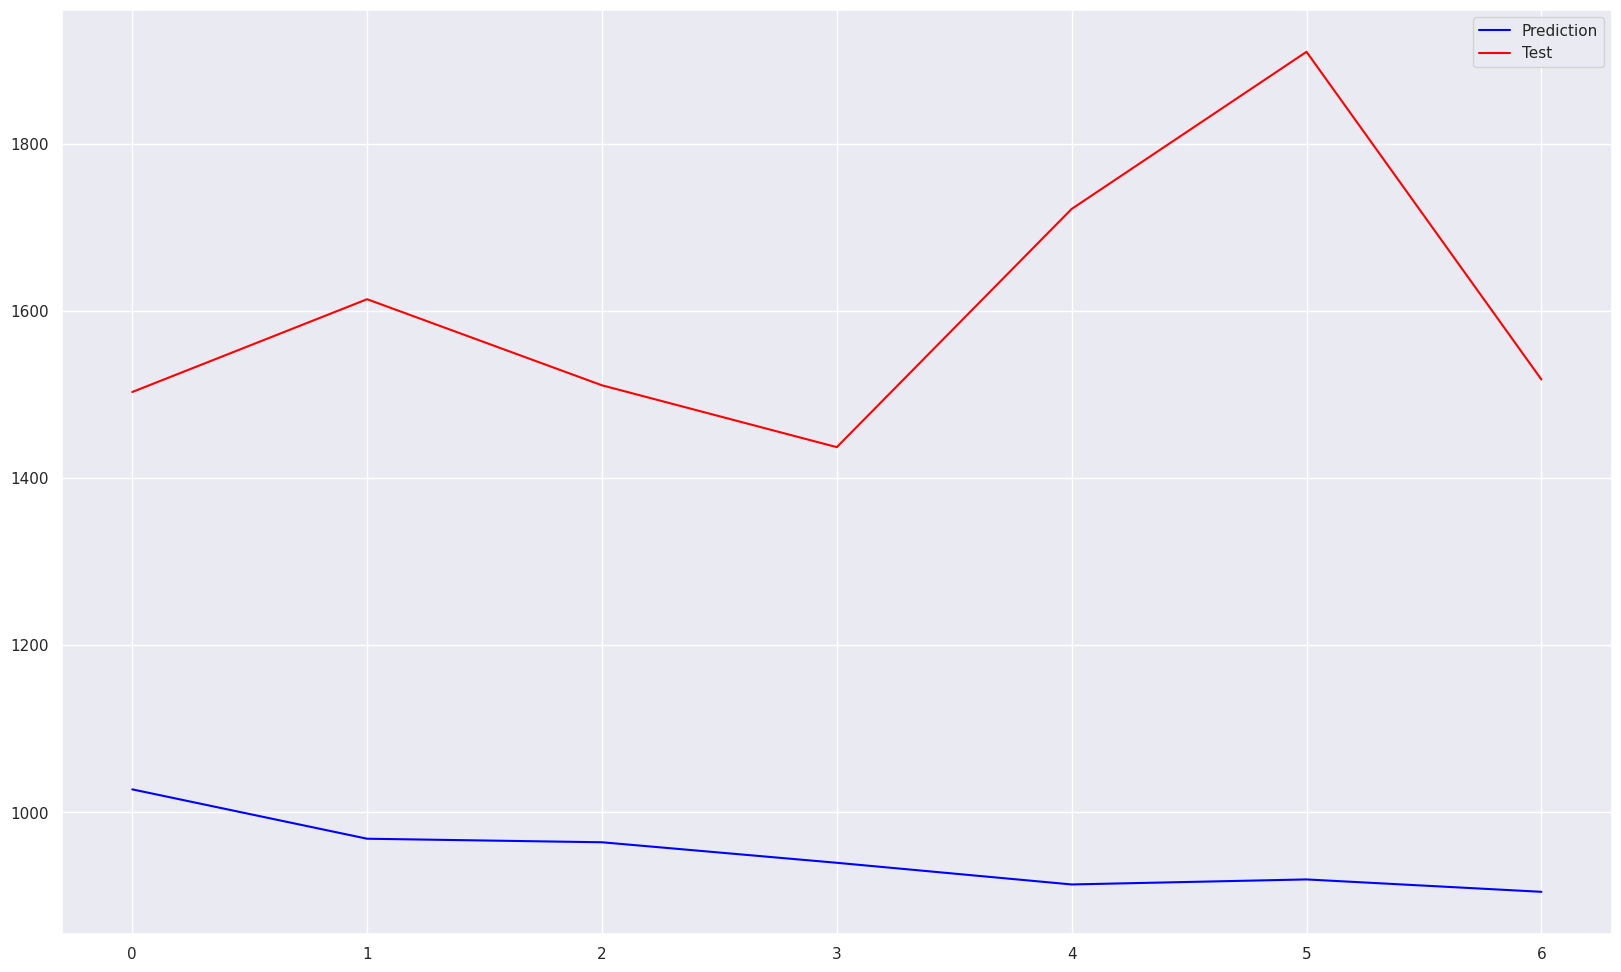

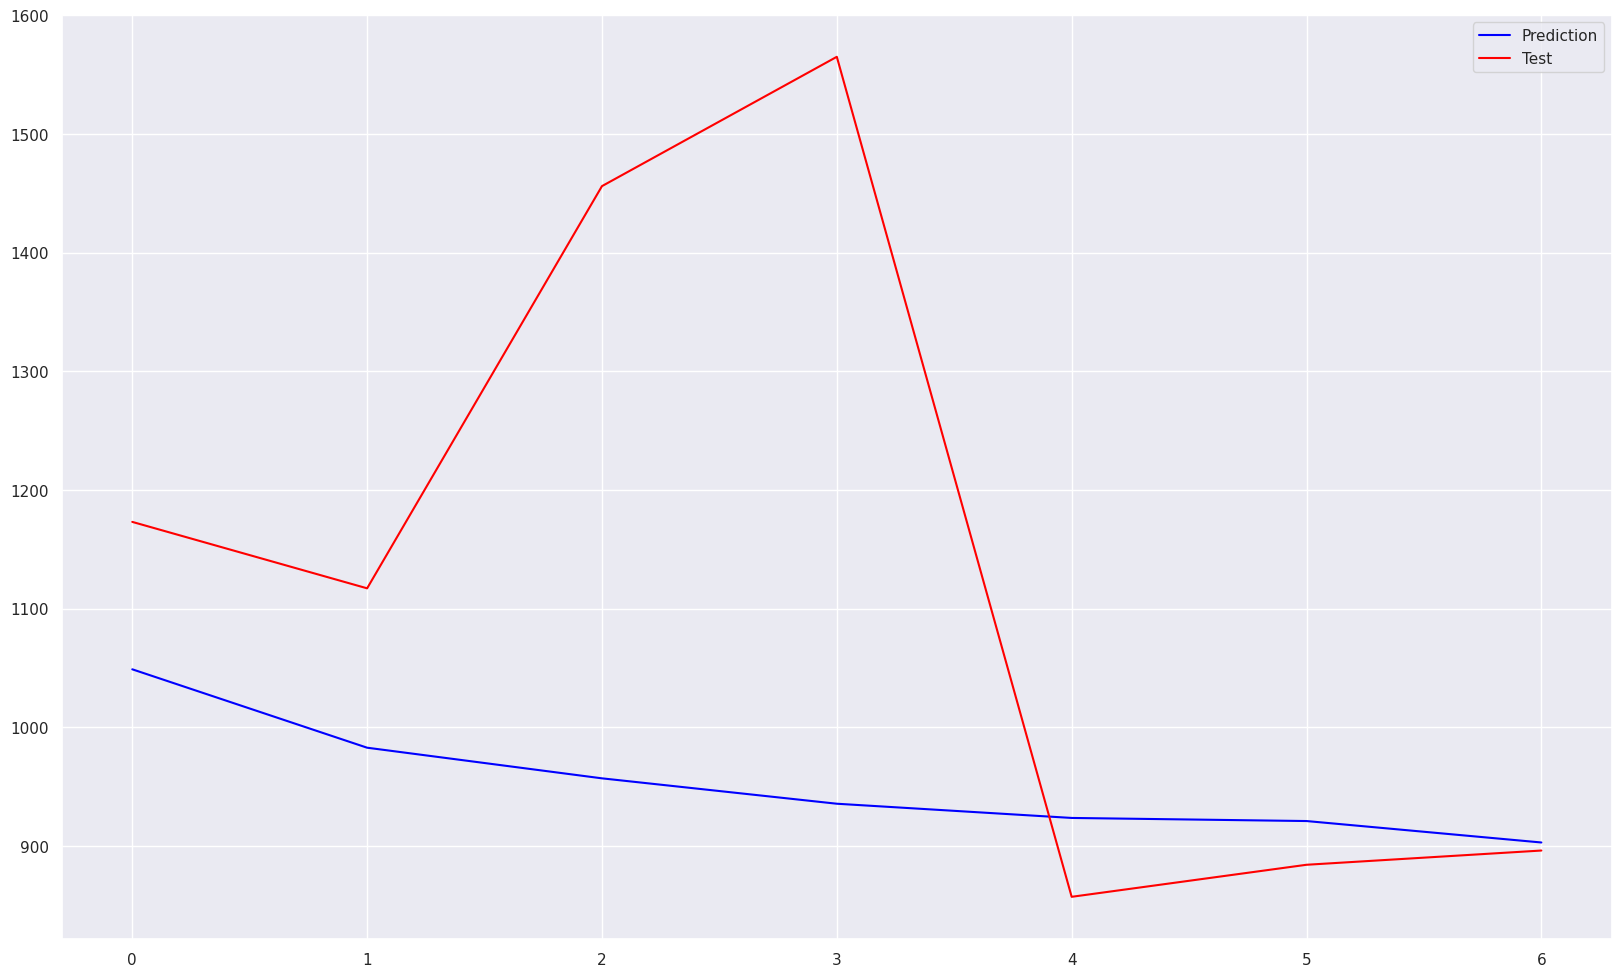

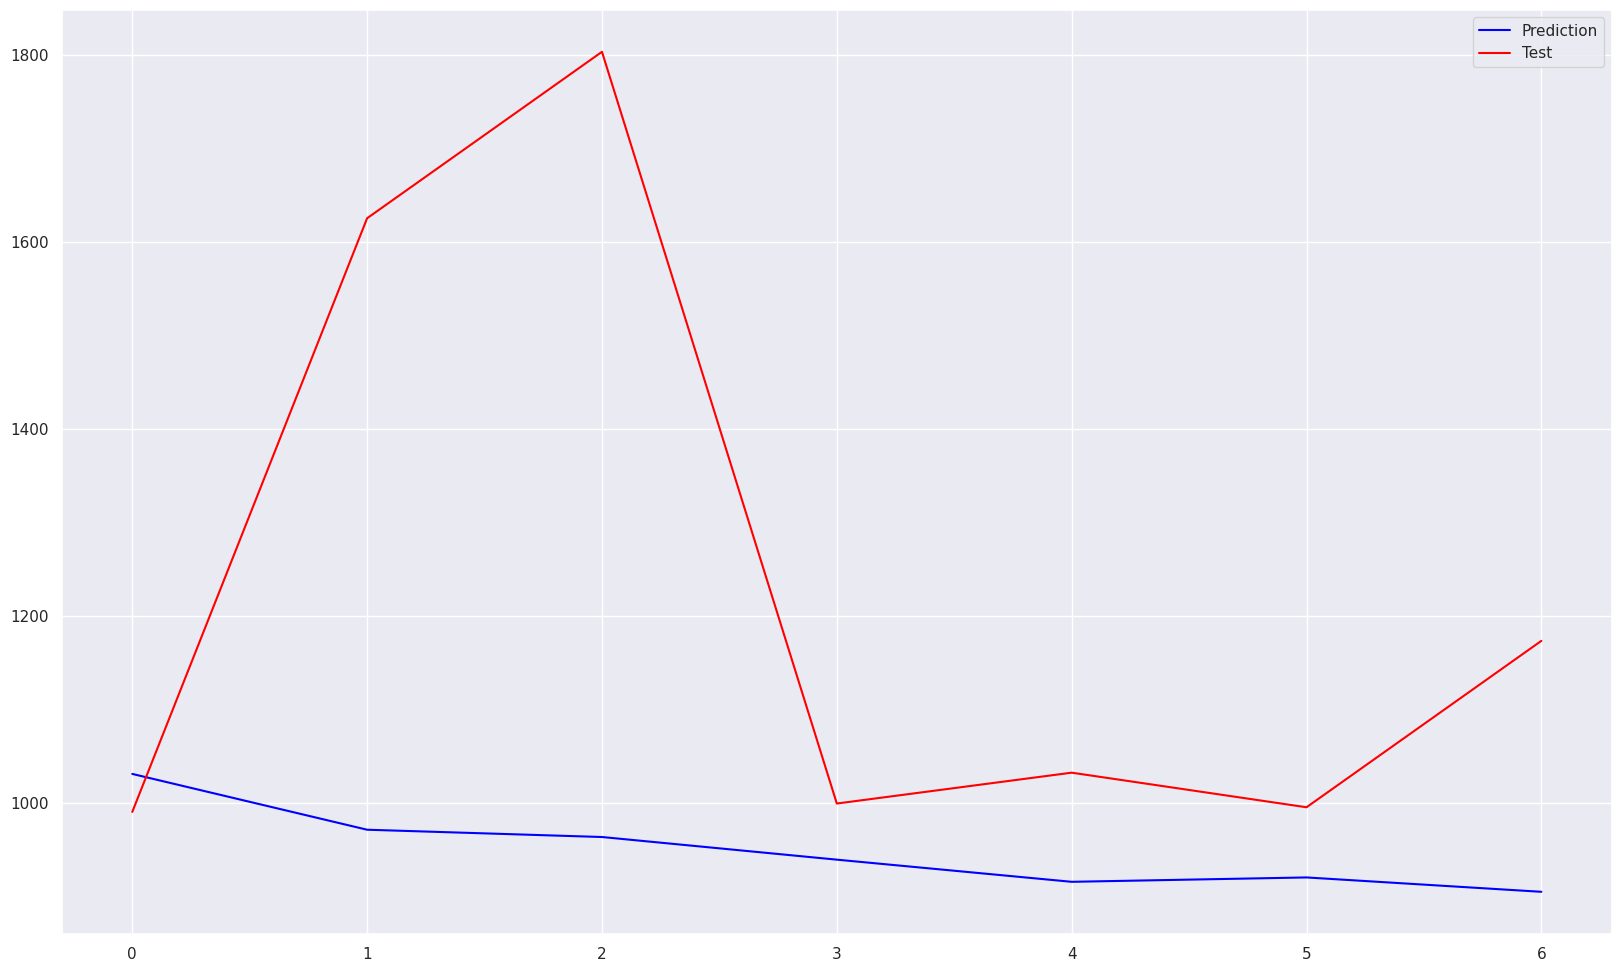

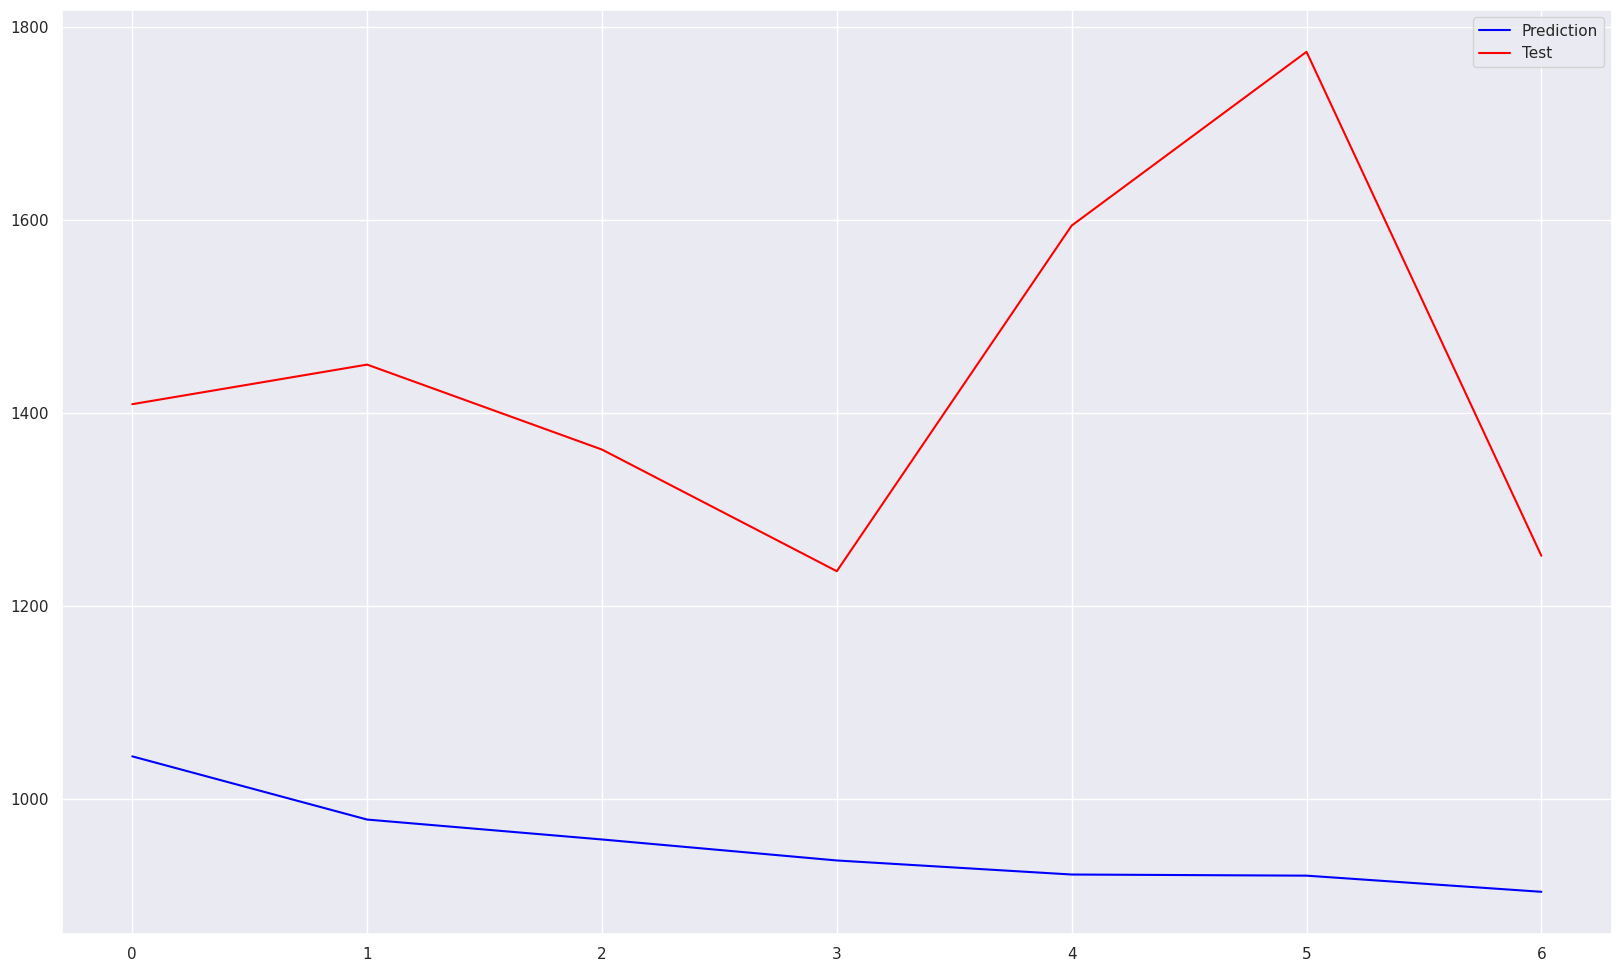

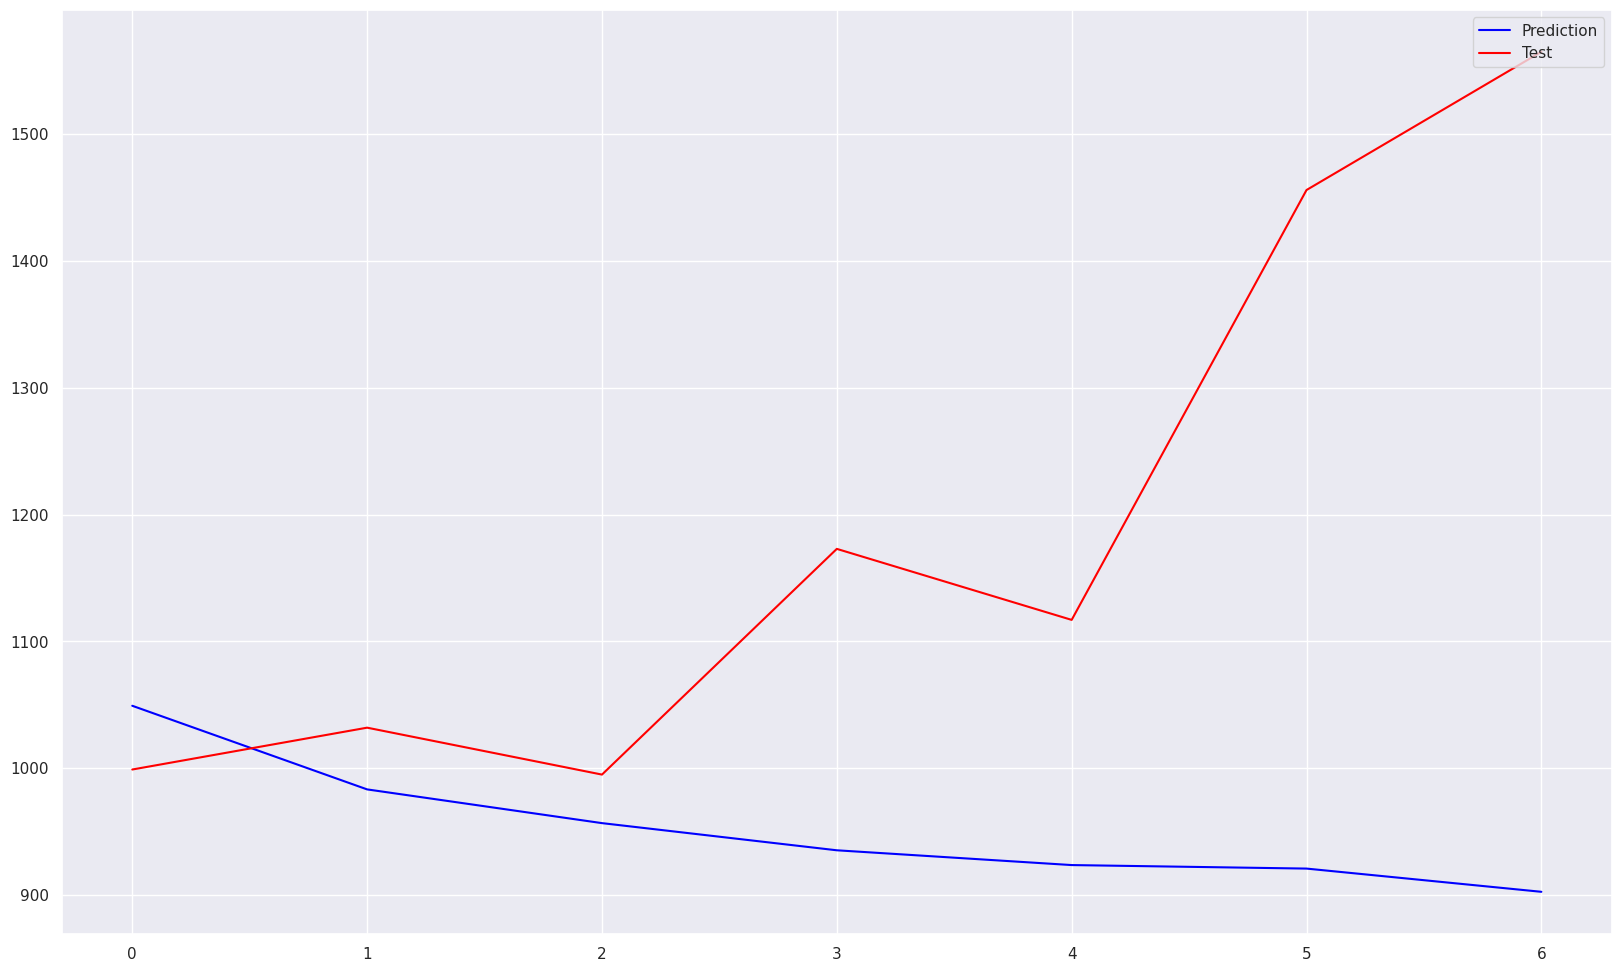

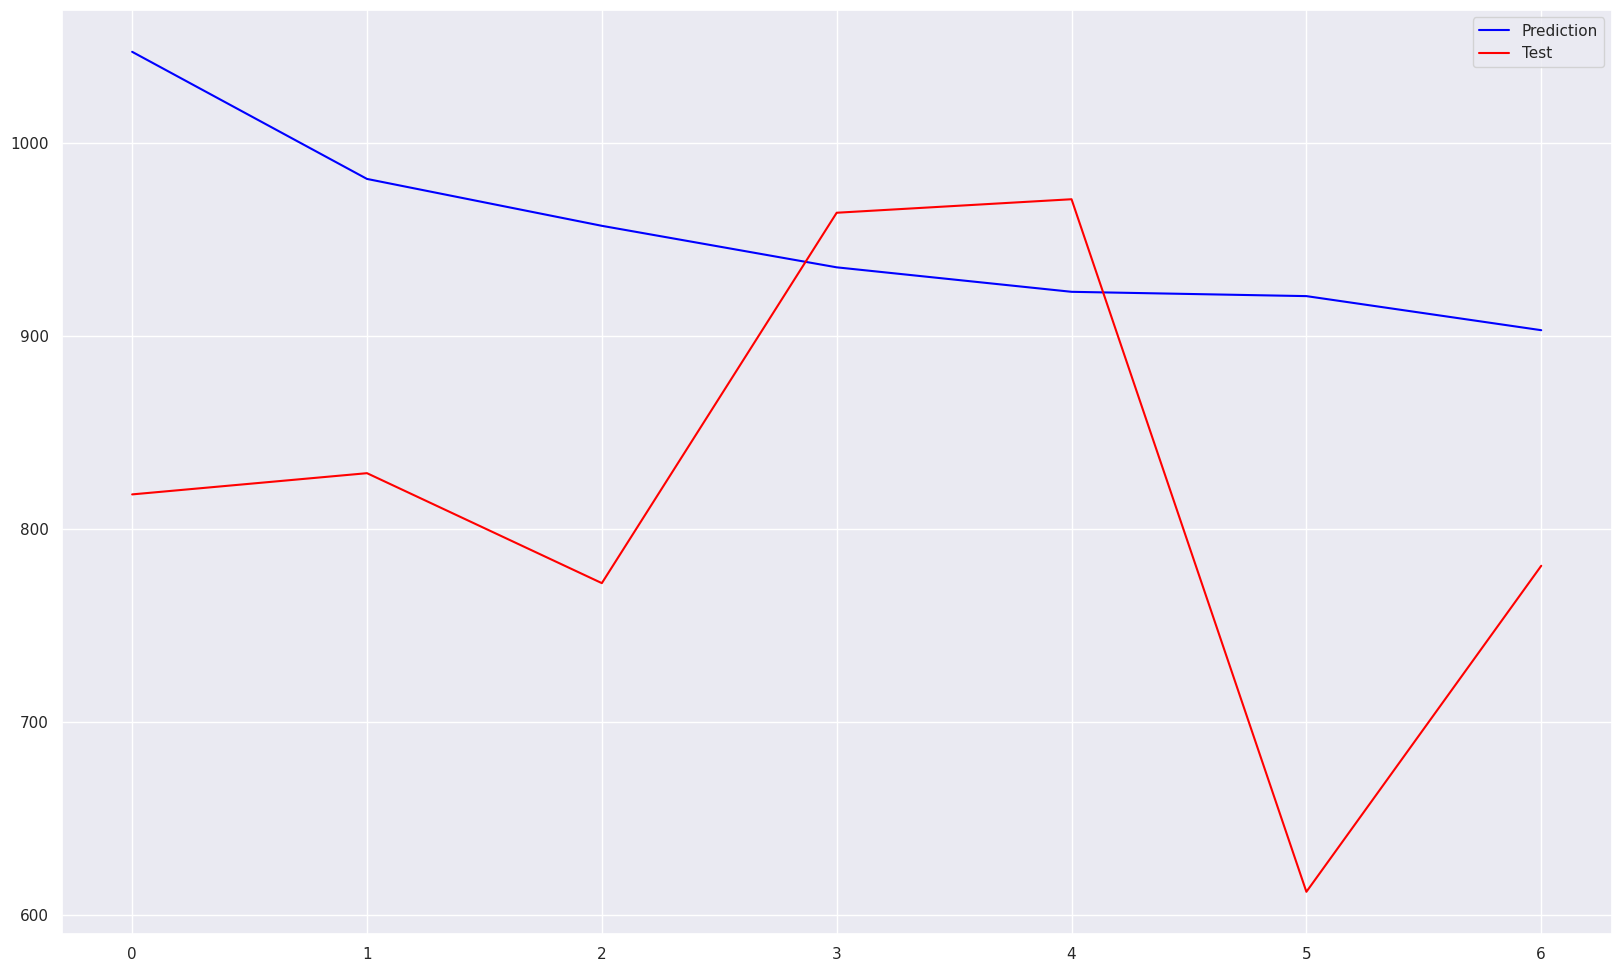

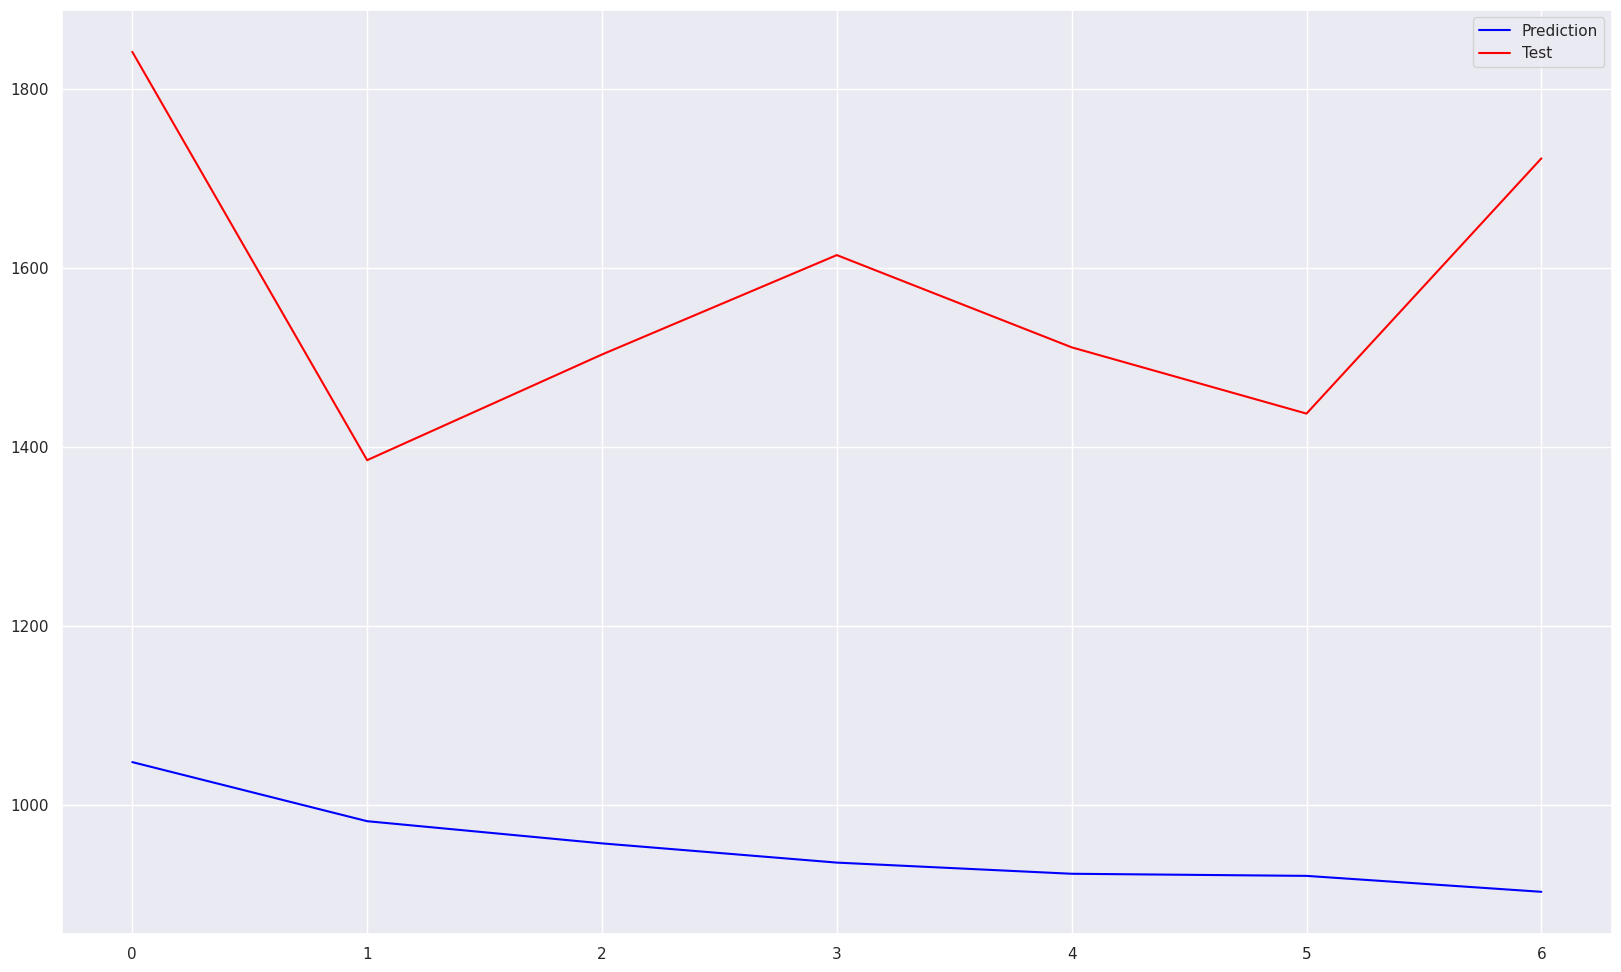

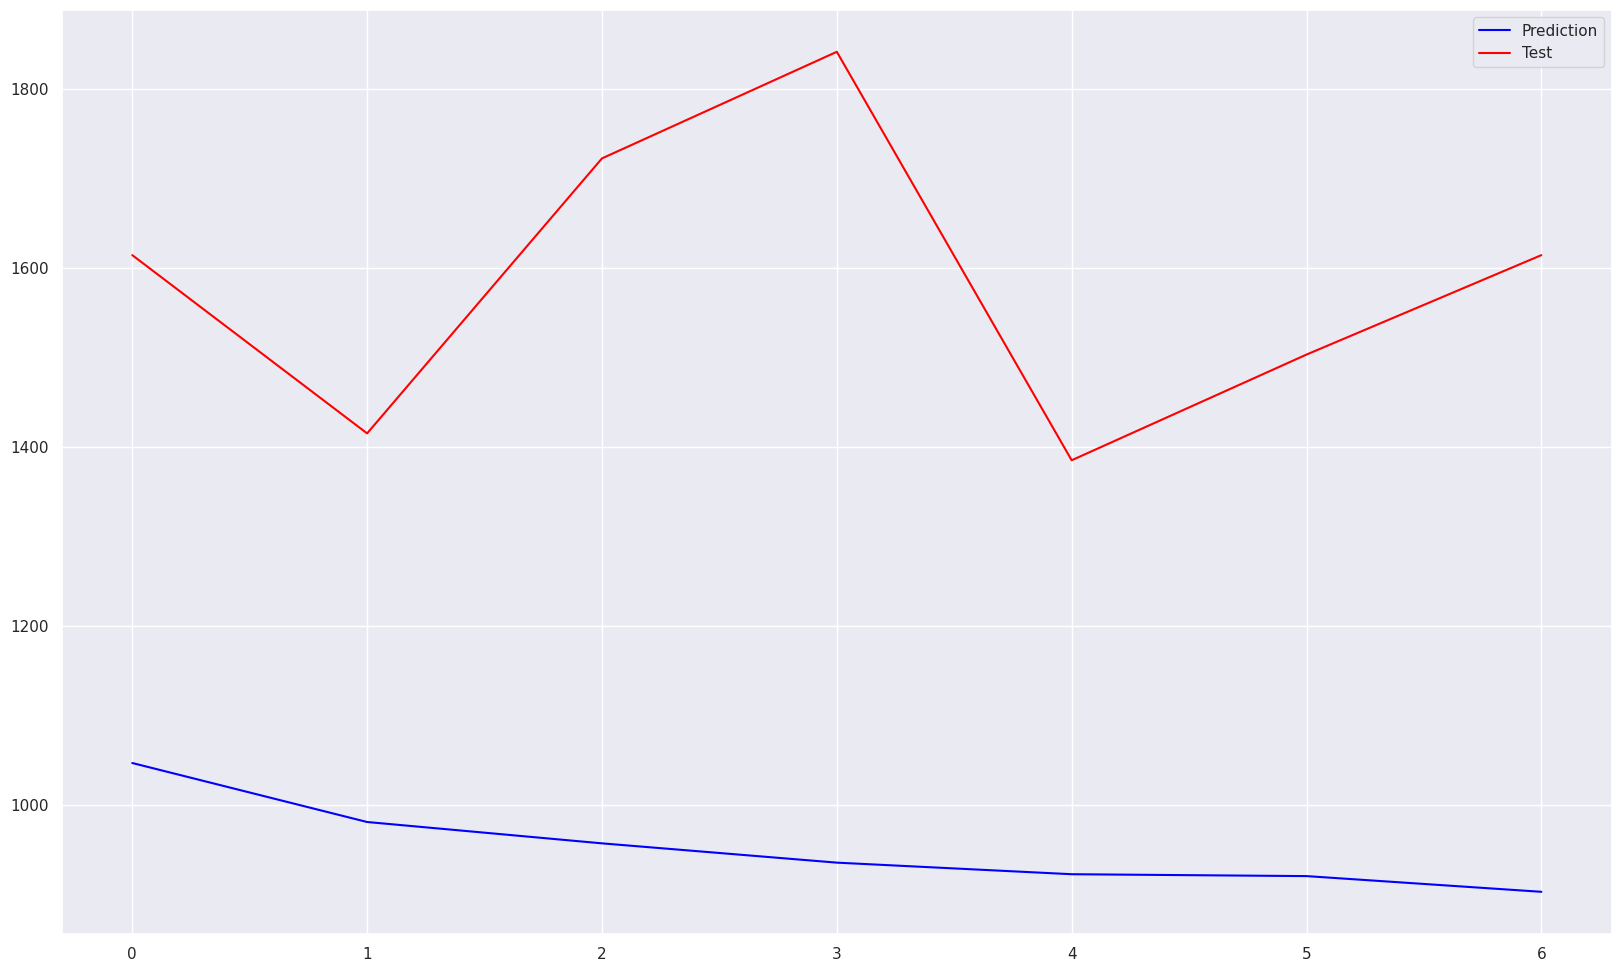

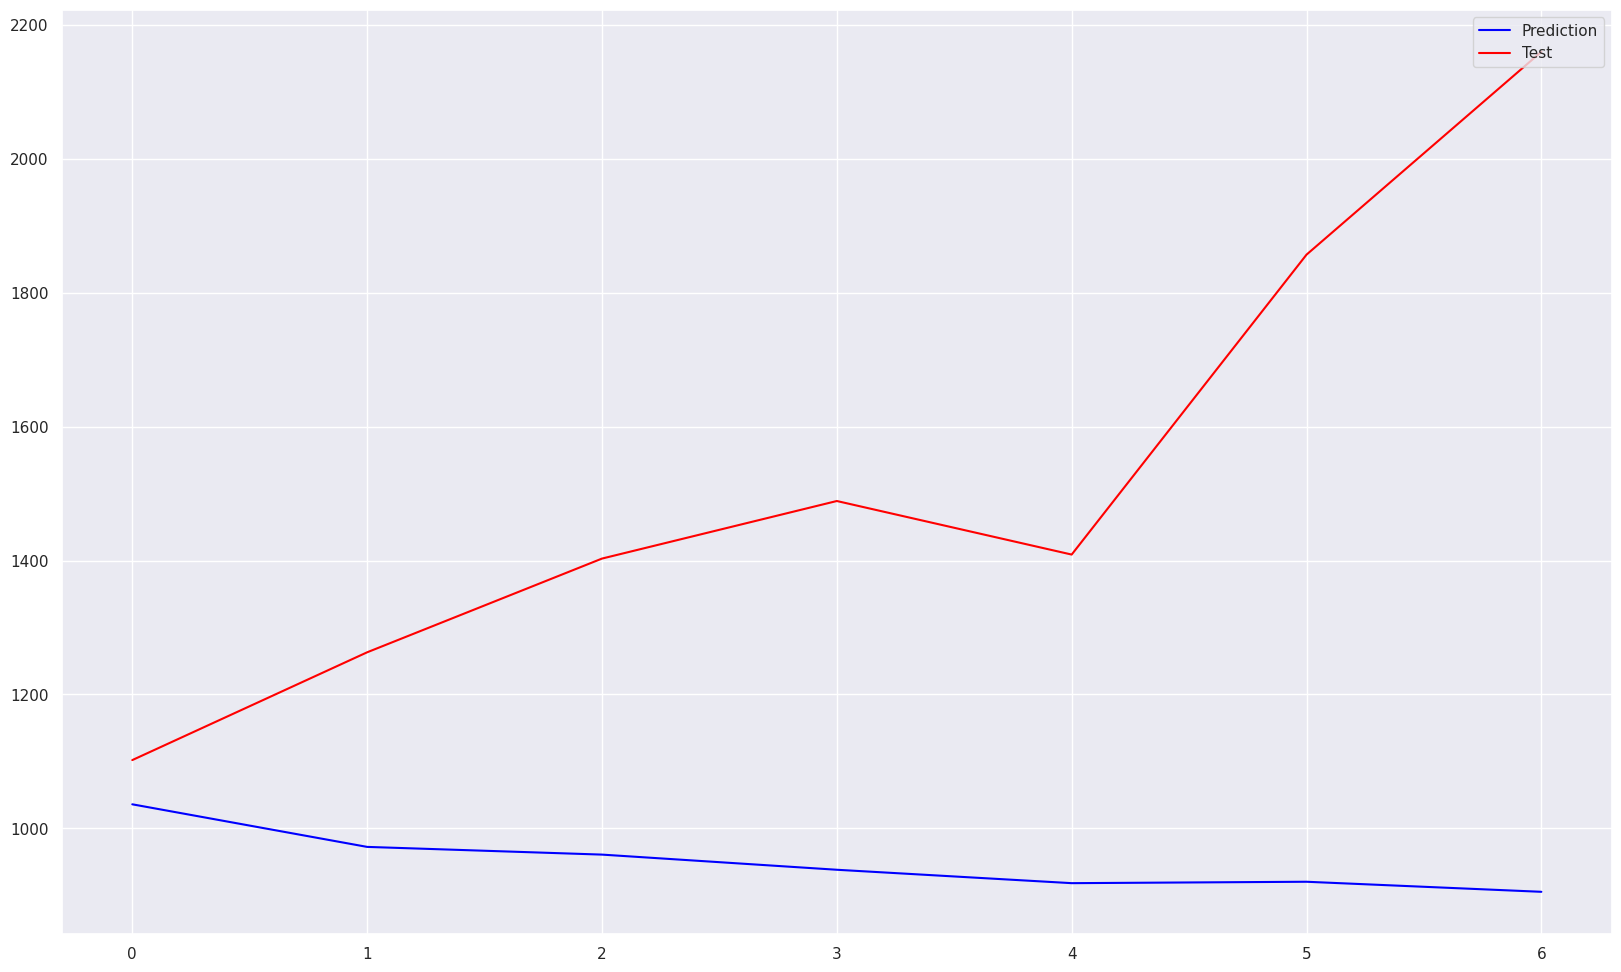

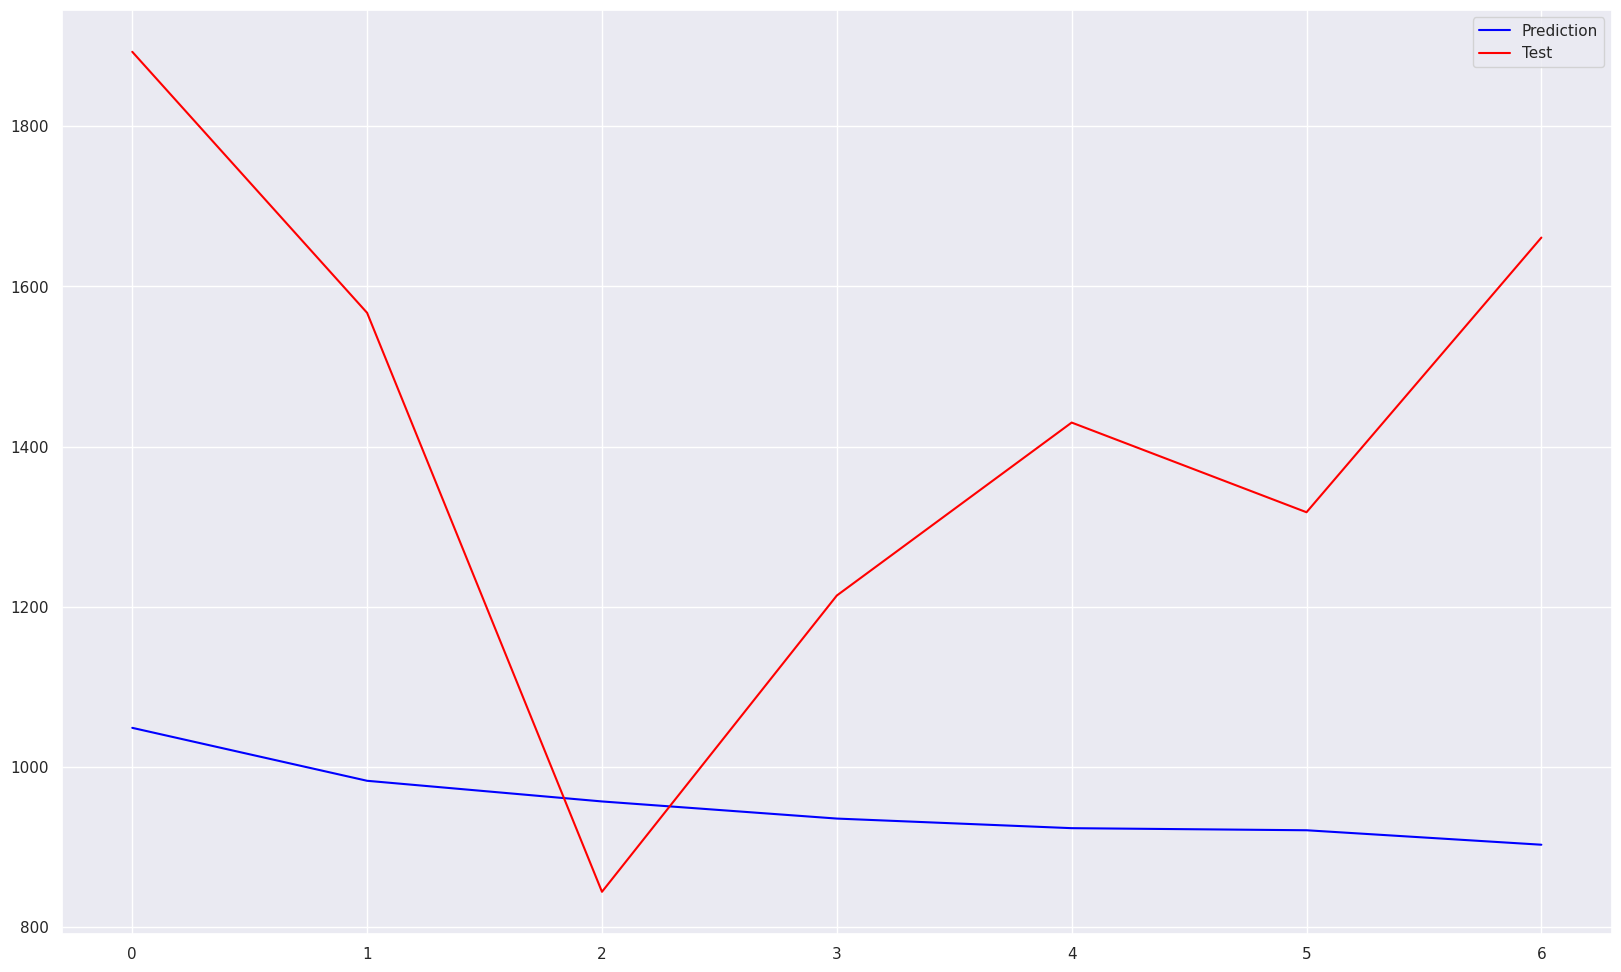

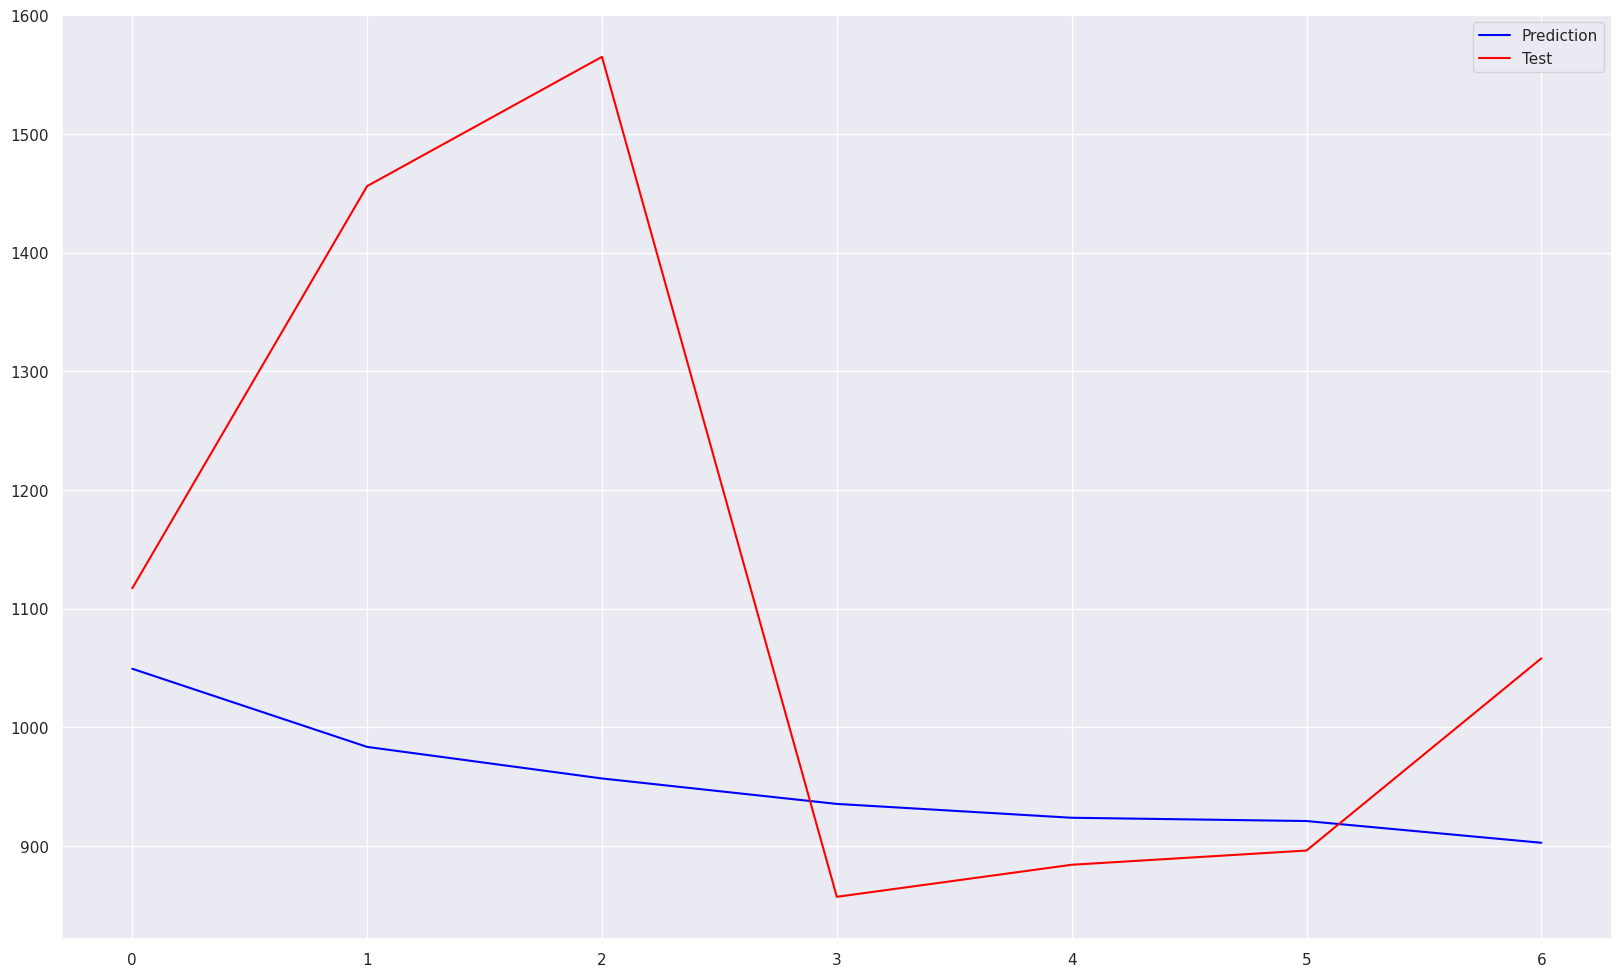

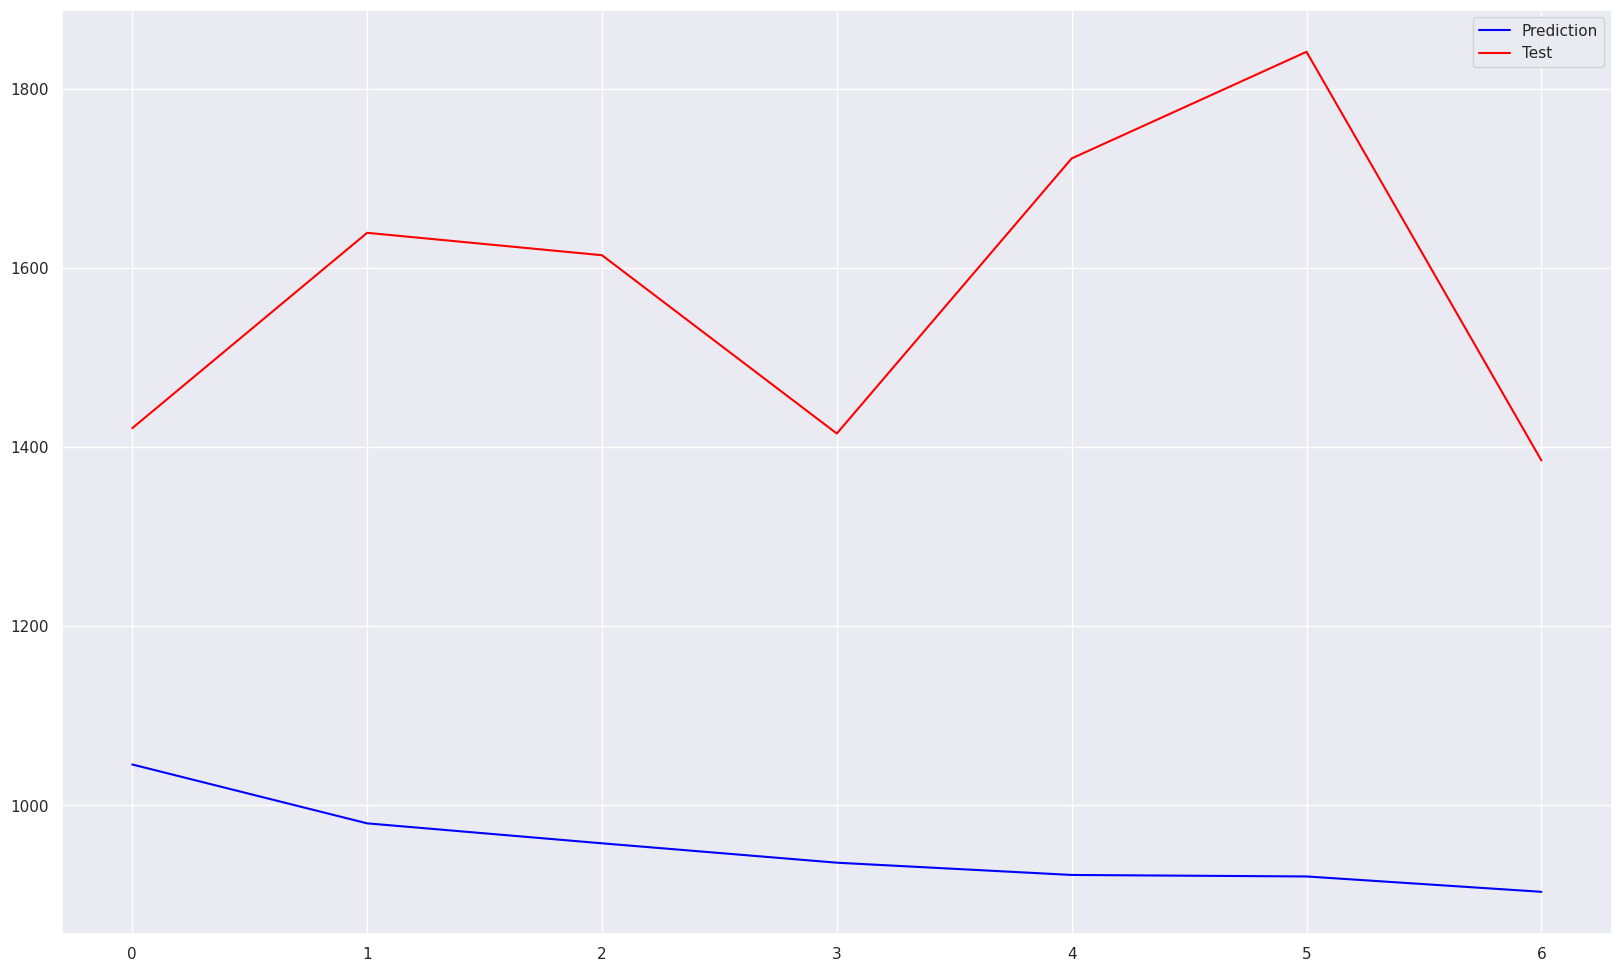

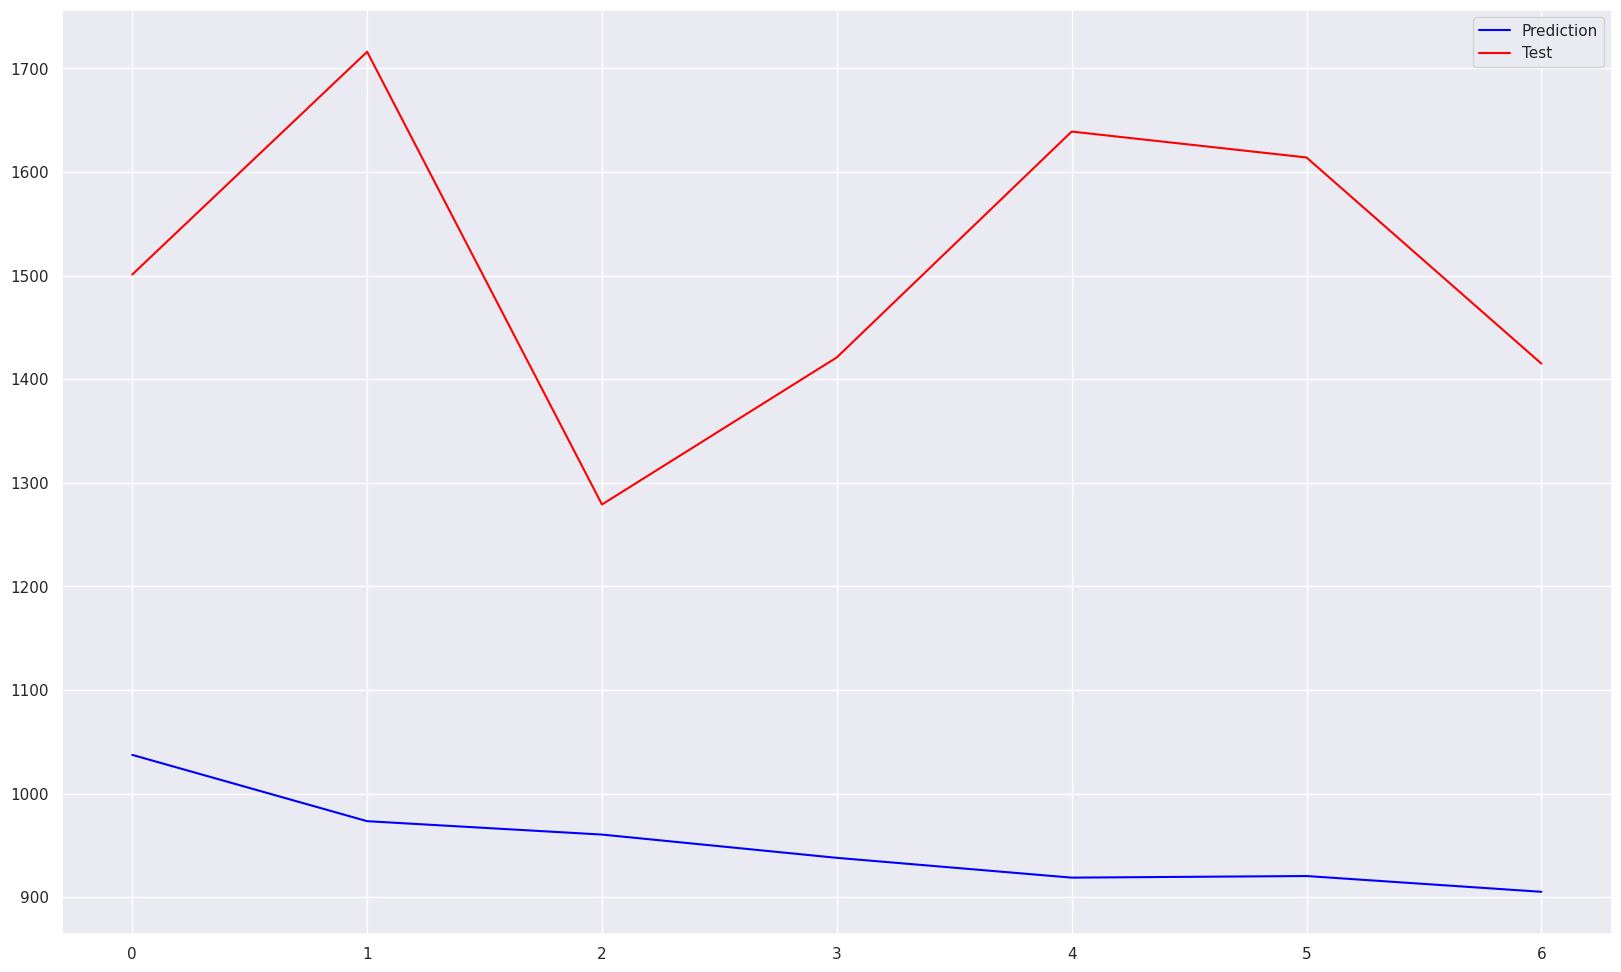

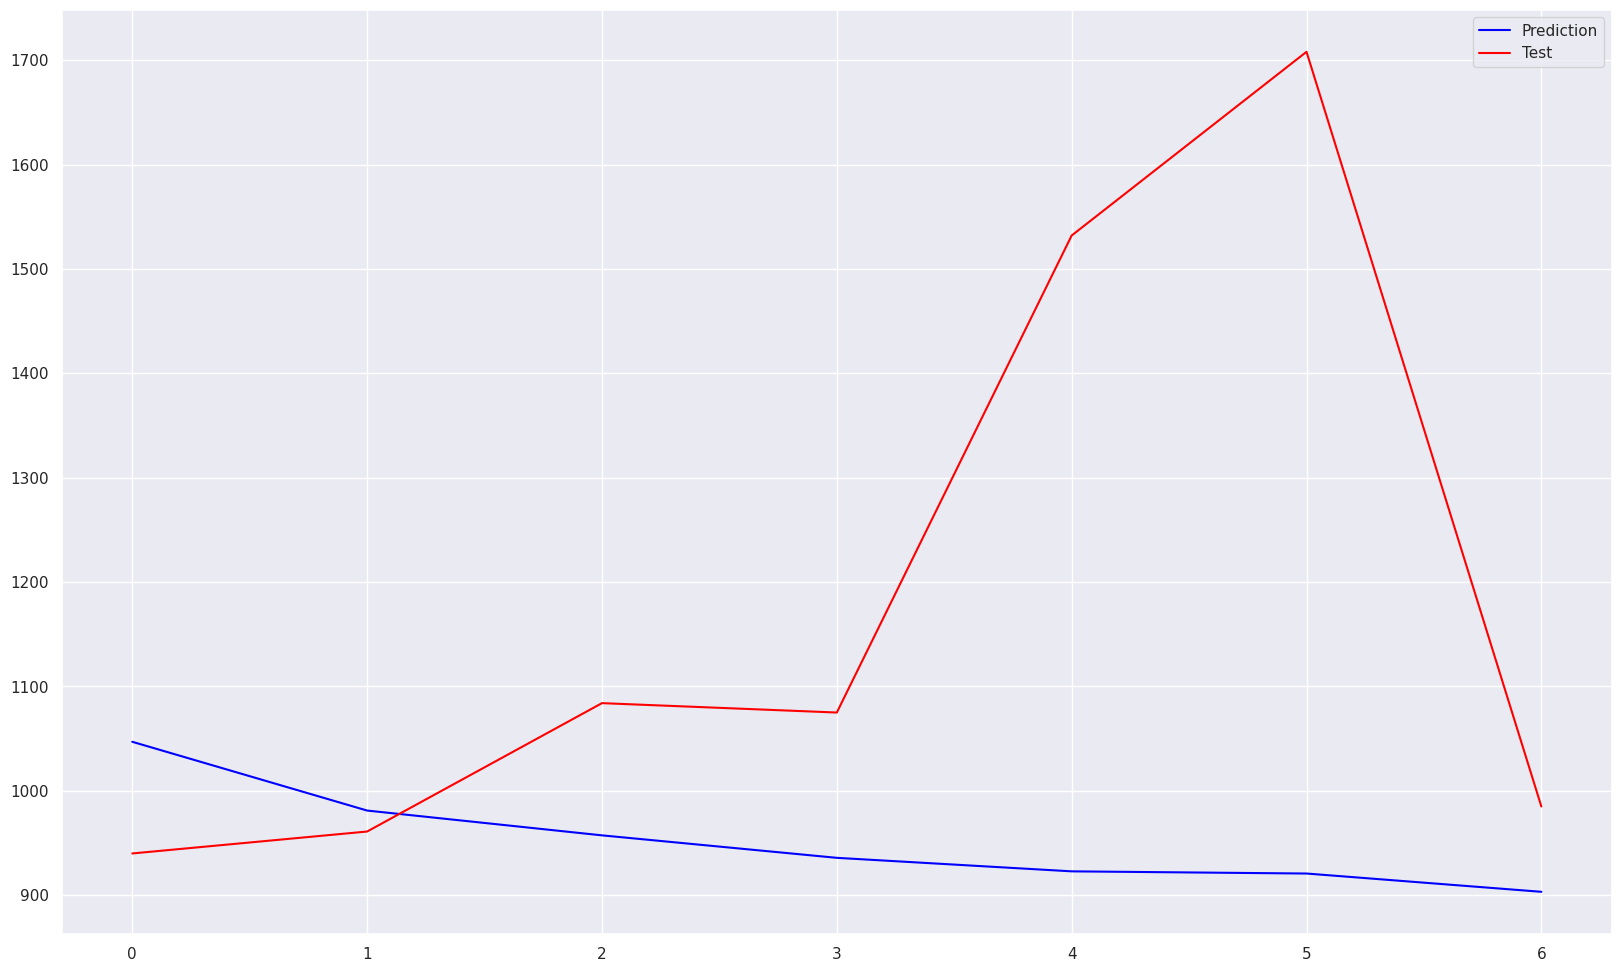

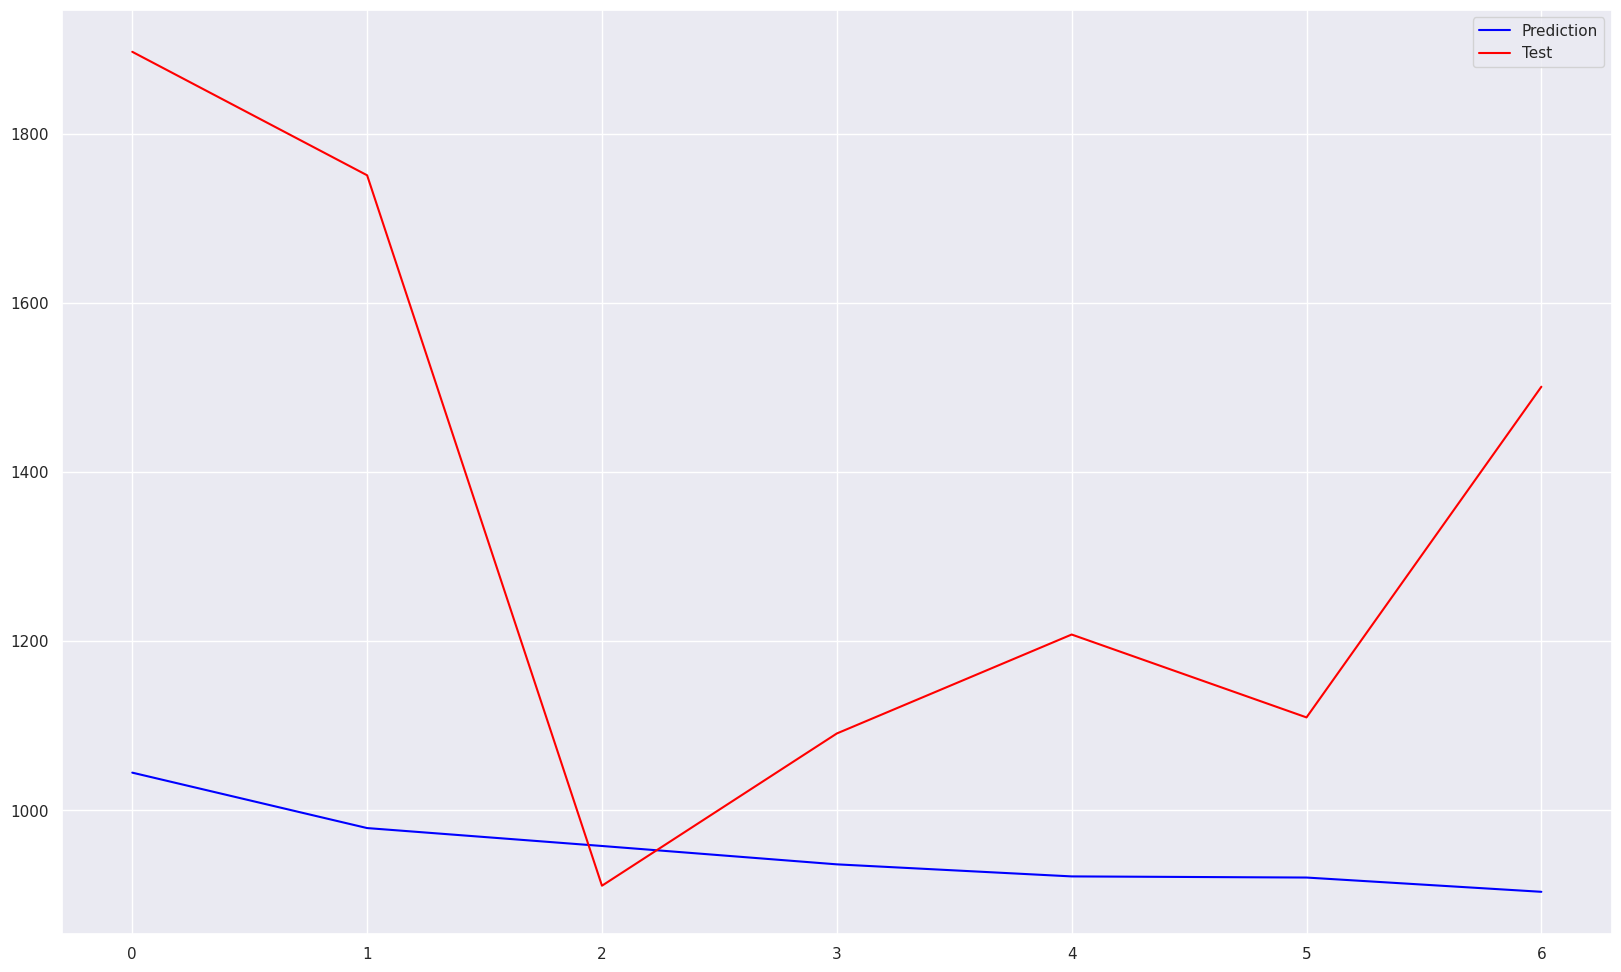

In [125]:
for i in range(y_pred.shape[0]):
    fig = plt.gcf(); fig.set_size_inches(20, 12);
    plt.plot(y_pred[i, :], c="blue", label="Prediction")
    plt.plot(y_test[i, :], c="red", label="Test")
#     plt.ylim(0, 430)
    plt.legend(loc='upper right')
    plt.show();

In [127]:
dl_error = np.mean(abs(y_pred - y_test))

In [128]:
base_error = np.mean(abs((df[['nb_cars']]-df[['nb_cars']].shift(7)).dropna()))[0]
base_error

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


212.9205921938089

In [129]:
print(
    f"DL model predicts with an average error of        {round(dl_error, 2)} cars"
    "\n"
    f"1 Week before predicts with an average error of  {round(base_error, 2)} cars"
)

DL model predicts with an average error of        430.33 cars
1 Week before predicts with an average error of  212.92 cars


In [130]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: LOSS ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('LOSS')
    ax[0].set_xlabel('EPOCH')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRICS: MAE ---

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('Mean Absolute Error')
    ax[1].set_ylabel('LOSS')
    ax[1].set_xlabel('EPOCH')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax

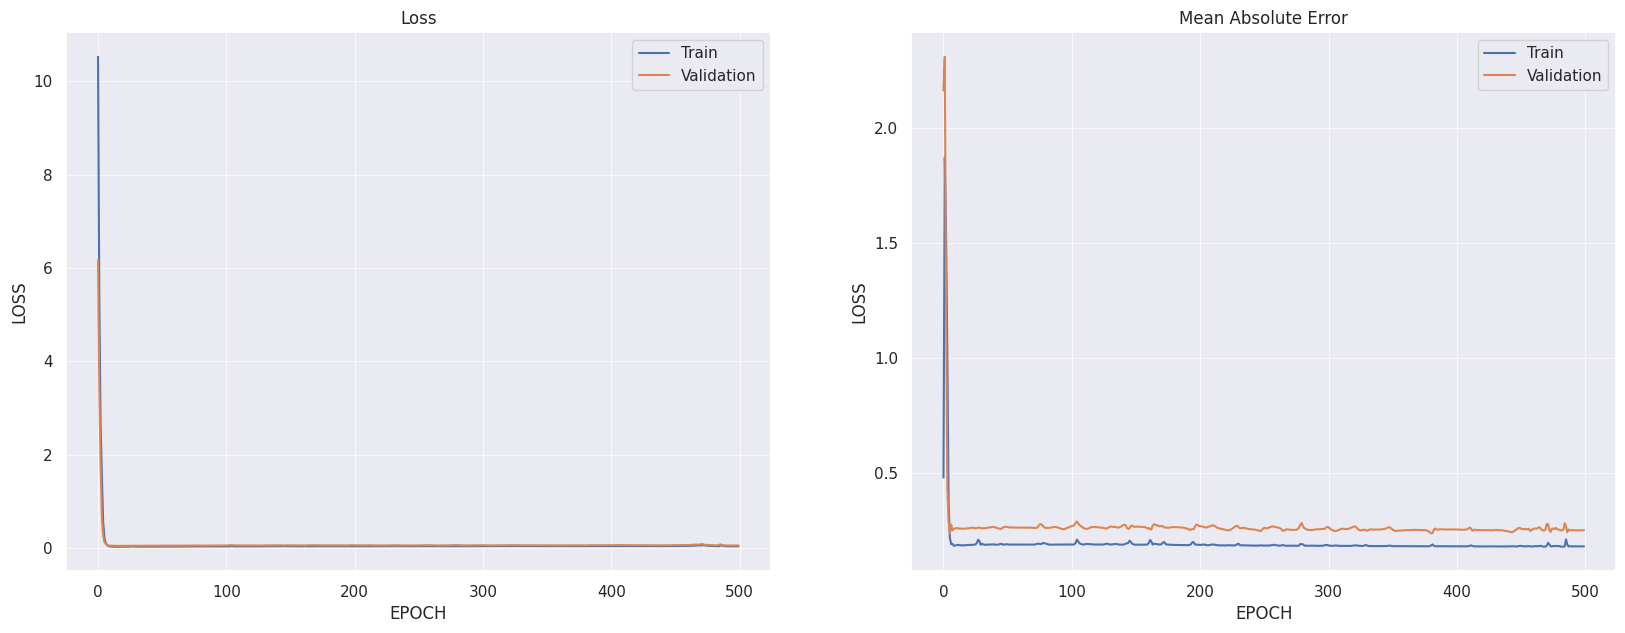

In [131]:
plot_history(history);